# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d100/2f0bb04162655f0cba429b865292f31482e817e0b3ee9da0f40185d7.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Chelmsford, Essex, United Kingdom**, and the stations the data comes from are shown on the map below.

In [46]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()
    print(lons)
    print(lats)
    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display(fig=plt.figure(),crs={'init' :'epsg:4326'})

leaflet_plot_stations(100,'2f0bb04162655f0cba429b865292f31482e817e0b3ee9da0f40185d7')

[2.9356, 3.6278, 2.9453, 3.2203, 3.275, -1.83, 0.5239, -1.535, 0.956, -1.993, -0.461, 1.3667]
[54.3256, 53.2692, 53.8242, 53.2178, 51.9978, 52.42, 53.1658, 54.292, 52.127, 51.505, 51.478, 51.35]


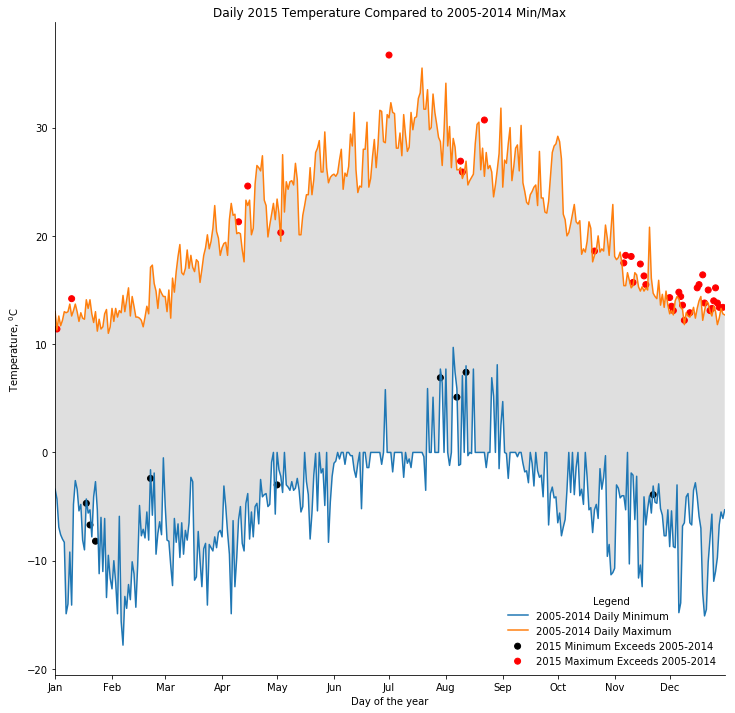

In [177]:
import pandas as pd
import matplotlib.dates as mdates
import re

# import the artist class from matplotlib
from matplotlib.artist import Artist

def plot_minmax(dataset):
    # Slurp in the dataset
    rawDF = pd.read_csv(dataset)
    rawDF = rawDF[rawDF["Date"] > "2005-01-01"]
    
    # Separate the TMIN and TMAX data and only that before 2015
    minDF = rawDF[rawDF["Element"] == "TMIN"]
    minDF = minDF[minDF["Date"] < "2015-01-01"]
    
    # Create a Mth_Day column that has a date set to 2000-MM-YY
    minDF['Mth_Day'] = minDF['Date'].map( lambda x : re.sub("(\d\d\d\d)-(\d\d)-(\d\d)",r"2000-\2-\3", x))
    maxDF = rawDF[rawDF["Element"] == "TMAX"]
    maxDF = maxDF[maxDF["Date"] < "2015-01-01"]
    maxDF['Mth_Day'] = rawDF['Date'].map( lambda x : re.sub("(\d\d\d\d)-(\d\d)-(\d\d)",r"2000-\2-\3", x))

    # Find min or max value on each day of year, irrespective of the year
    minDF = minDF.groupby(["Mth_Day"]).agg("min")
    maxDF = maxDF.groupby(["Mth_Day"]).agg("max")
    
    # Merge the min and max data (probably not needed)
    minMaxDF = pd.merge(minDF, maxDF, how="inner", left_index=True, right_index=True)
    #print(minMaxDF)

    # Let's get into the right units for display and sort out the column names
    minMaxDF["Min"]=minMaxDF["Data_Value_x"]/10
    minMaxDF["Max"]=minMaxDF["Data_Value_y"]/10
    minMaxDF = minMaxDF[["Min","Max"]]
    #print("A")
    
    # Separate out the TMIN and TMAX data for each day since start of 2015
    # These values get compared to the earlier min/max
    minDF2 = rawDF[rawDF["Element"] == "TMIN"]
    minDF2 = minDF2[minDF2["Date"] >= "2015-01-01"]
    minDF2['Mth_Day'] = minDF2['Date'].map( lambda x : re.sub("(\d\d\d\d)-(\d\d)-(\d\d)",r"2000-\2-\3", x))
    maxDF2 = rawDF[rawDF["Element"] == "TMAX"]
    maxDF2 = maxDF2[maxDF2["Date"] >= "2015-01-01"]
    maxDF2['Mth_Day'] = maxDF2['Date'].map( lambda x : re.sub("(\d\d\d\d)-(\d\d)-(\d\d)",r"2000-\2-\3", x))

    minDF2 = minDF2.groupby(["Mth_Day"]).agg("min")
    maxDF2 = maxDF2.groupby(["Mth_Day"]).agg("max")
    
    # Again a merge which probably isn't needed but it's nicer!
    minMaxDF2 = pd.merge(minDF2, maxDF2, how="inner", left_index=True, right_index=True)
    #print(minMaxDF)

    # Get the units right again
    minMaxDF2["Min2015"]=minMaxDF2["Data_Value_x"]/10
    minMaxDF2["Max2015"]=minMaxDF2["Data_Value_y"]/10
    minMaxDF2 = minMaxDF2[["Min2015","Max2015"]]
    
    # Finally we're pulling all the data together
    compDF = pd.merge(minMaxDF, minMaxDF2, how="inner", left_index=True, right_index=True)
 
    # All the days where 2015 values were more extreme than the 2000-2014 high/lows
    min2015DF = compDF[compDF["Min2015"] < compDF["Min"]]
    max2015DF = compDF[compDF["Max2015"] > compDF["Max"]]
    #print(min2015DF)
    #print(max2015DF)
    
    # Lets visualise this for folks at home ...
    # observations will be the days of the year along the x-axis, we only put the month in the 
    observations = minMaxDF.index.values

    # Create a nice big plot so we can see what's going on
    fig, ax = plt.subplots(figsize=(12,12))
    
    # Plot the min and max data
    ax.plot(list(map(pd.to_datetime,observations)), minMaxDF["Min"], label="2005-2014 Daily Minimum")
    ax.plot(list(map(pd.to_datetime,observations)), minMaxDF["Max"], label="2005-2014 Daily Maximum")

    # Shade the area between high and low
    plt.gca().fill_between(observations,minMaxDF["Min"],minMaxDF["Max"],facecolor="grey",alpha=0.25)

    # Plot the 2015 minimums that are lower than the 2000-2014 minimums
    # Repeat for the maximums
    ax.scatter(list(map(pd.to_datetime,min2015DF.index.values)),min2015DF["Min2015"],c=['black']*(len(min2015DF)-1),
               label="2015 Minimum Exceeds 2005-2014")
    ax.scatter(list(map(pd.to_datetime,max2015DF.index.values)),max2015DF["Max2015"],c=['red']*(len(max2015DF)-1),
               label="2015 Maximum Exceeds 2005-2014")

    # Give the chart a title
    plt.title("Daily 2015 Temperature Compared to 2005-2014 Min/Max")
    # Label the x and y axes
    plt.xlabel("Day of the year")
    plt.ylabel("Temperature, $^0$C")
    
    # Add a legend
    plt.legend(loc=4, frameon=False,title="Legend")
    
    # x-axis labels must show only the months of year at major separators
    months = mdates.MonthLocator()
    monthsFmt = mdates.DateFormatter("%b")
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)

    # It's bugging me there is extra values on the x-axis so trim this to size
    plt.xlim(pd.to_datetime(observations[0]),pd.to_datetime(observations[len(observations)-1]))


    # Let's remove the top and right spine
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    plt.show()

    return

plot_minmax("data/assignment2_data.csv")
#plot_minmax("data/C2A2_data/BinnedCsvs_d100/2f0bb04162655f0cba429b865292f31482e817e0b3ee9da0f40185d7.csv")